In [1]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
#Timeseries

df = pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab8/weather.csv')
df.drop(['temp_max', 'temp_min'], axis=1, inplace=True)
df


,date,radiation_avg,precip,wind_avg,wind_max,temp_avg,humidity_avg
0,14/05/2014 00:00,159,0.0,1.4,3.3,14.27,64.95
1,15/05/2014 00:00,280,0.0,0.6,2.3,13.51,72.91
2,16/05/2014 00:00,186,3.4,0.8,2.7,15.65,74.69
3,17/05/2014 00:00,221,0.0,1.0,3.3,17.46,71.42
4,18/05/2014 00:00,255,0.0,2.1,5.5,16.85,74.45
...,...,...,...,...,...,...,...
2551,17/05/2021 00:00,196,1.4,2.2,5.5,10.51,99.86
2552,17/05/2021 00:00,173,2.8,1.8,5.5,10.80,99.86
2553,18/05/2021 00:00,311,0.0,1.4,5.0,10.29,92.94
2554,19/05/2021 00:00,232,6.6,1.8,5.5,11.39,90.32


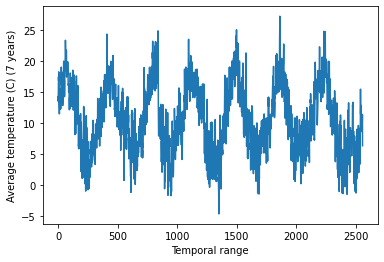

In [3]:
#plot

plt.plot(range(len(df)), df['temp_avg'])
plt.xlabel('Temporal range')
plt.ylabel('Average temperature (C) (7 years)')
plt.savefig('temperature_over_time.pdf', bbox_inches='tight')

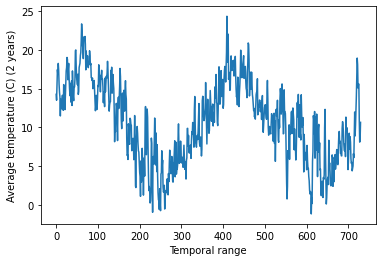

In [4]:
# Look at the first 2 years

length = 2*365

plt.plot(range(length), df['temp_avg'][:length])
plt.xlabel('Temporal range')
plt.ylabel('Average temperature (C) (2 years)')
plt.savefig('temperature_over_time_2y.pdf', bbox_inches='tight')

In [5]:
#Data prep

#We'll try to predict the average temperature of tomorrow based on data from the past.
#To avoid data leakage, we're going to use a simple approach: use the first 50% of data for training, the next 30% for validation, and the final 20% for testing.

n_tr, n_val = int(0.5*len(df)), int(0.3*len(df))
n_te = len(df) - n_tr - n_val
print('Samples for training: %d; validation: %d; test: %d' % (n_tr, n_val, n_te))

Samples for training: 1278; validation: 766; test: 512


In [6]:
# Get the data from the dataframe (dropping date column)

data = df.iloc[:, 1:].values
print(data.shape)

assert data.shape[0] == len(df)
assert data.shape[1] == len(df.columns)-1, "Are you sure you're dropping the date?"

# We need to normalise our time series (NNs expect normalized data). Calculate mean and std from TRAINING DATA ONLY. 
# We'll use it on the validation and test sets.

mean_tr = data[:n_tr, :].mean(axis=0)
std_tr = data[:n_tr, :].std(axis=0)
data = (data - mean_tr) / std_tr


y = df['temp_avg'].values.reshape(-1, 1)

# index of the column that contains the avg_temp
y_idx = 4

(2556, 6)


In [7]:
data[:20, y_idx] * std_tr[y_idx] + mean_tr[y_idx]

array([14.27, 13.51, 15.65, 17.46, 16.85, 18.26, 17.35, 15.55, 14.52,
       13.93, 11.48, 13.63, 12.81, 12.4 , 13.67, 14.15, 13.22, 12.21,
       15.53, 14.52])

In [8]:
y[5:25]


array([[18.26],
       [17.35],
       [15.55],
       [14.52],
       [13.93],
       [11.48],
       [13.63],
       [12.81],
       [12.4 ],
       [13.67],
       [14.15],
       [13.22],
       [12.21],
       [15.53],
       [14.52],
       [15.35],
       [12.29],
       [13.88],
       [15.13],
       [17.29]])

In [9]:
# We'll use a Dataset from keras to pass our data

# we keep all data points:
sampling_rate = 1      

# 2 weeks to predict tomorrow's temperature:
sequence_length = 14 

# the target is the day after the end of the sequence:
delay = sampling_rate * sequence_length  
batch_size = 16

In [10]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],                #X
    targets=y[delay:],            #Y
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=0, end_index=n_tr                    # first 50% for training
    )

val_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=n_tr, end_index=n_tr+n_val          # 50%-80% for validation
    )

test_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=n_tr+n_val                          # last 20% for test
    )

#count=0
for X, target in train_dataset:
    print("X shape:", X.shape)
    print("target shape:", target.shape)
    
    #print(X[:, :, y_idx] * std_tr[y_idx] + mean_tr[y_idx])
    #print(target)
    
    break  # so we only print once

X shape: (16, 14, 6)
target shape: (16, 1)


In [12]:
# Function to plot history with neural networks


def plot_hist_regression(hist, y):
    n_ = len(hist.history['mae'])
    plt.plot(range(1, n_+1), np.asarray(hist.history['mae']), 'bo', label='MAE on training set')
    plt.plot(range(1, n_+1), np.asarray(hist.history['val_mae']), 'b', label='MAE on validation set')
    plt.legend()
    # plt.ylim(0,100)
    plt.xlabel("Epoch") 
    plt.ylabel("MAE (degrees)")
    plt.axhline(y=y)
    plt.show()

In [13]:
#Establishing a baseline


#Common sense, no ML baseline
    #1) Sanity check
    #2) To establish whether ML methods are actually any good
#Tomorrow's temperature is likely to be close to today's: let's predict that the temperature 24 hours from now will be equal to the temperature right now.

#We'll use the MAE as metric:
def naive_method(dataset, mean, std):
    error = 0
    samples = 0
    count = 0
    for X, target in dataset:
             # predict last available temperature and un-standardise [standardizing=((val-mean) / std)]:
        pred = X[:, -1, y_idx] * std + mean 
        
        #print(X.shape, target.shape, pred.shape)  # [batch_size, sequence_length, n_feats]
        #print(X[:, -1, y_idx] * std + mean, target)
        
            # compare our pred with the ground truth:
        error += np.sum(np.abs(pred - target)) 
            # batch_size:
        samples += X.shape[0]  
        count += 1
    return error / samples / batch_size # average


print('MAE on train set = %.2f (degrees Celsius)' % naive_method(train_dataset, mean_tr[y_idx], std_tr[y_idx]))
print('MAE on validation set = %.2f (degrees Celsius)' % naive_method(val_dataset, mean_tr[y_idx], std_tr[y_idx]))
print('MAE on test set = %.2f (degrees Celsius)' % naive_method(test_dataset, mean_tr[y_idx], std_tr[y_idx]))

# Save MAE on validation for later
baseline = naive_method(val_dataset, mean_tr[y_idx], std_tr[y_idx])

MAE on train set = 2.56 (degrees Celsius)
MAE on validation set = 2.69 (degrees Celsius)
MAE on test set = 2.85 (degrees Celsius)


In [14]:
#Simple ML baseline

# To get some practice with neural networks, we'll try a 1-layer NN with nothing fancy.

model_dense = models.Sequential()

model_dense.add(layers.Flatten(input_shape=(sequence_length, len(df.columns)-1)))  # we need to specify the input shape or we won't be able to see the summary
model_dense.add(layers.Dense(10, activation='relu'))
model_dense.add(layers.Dense(1))

model_dense.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 84)                0         
                                                                 
 dense (Dense)               (None, 10)                850       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 861
Trainable params: 861
Non-trainable params: 0
_________________________________________________________________


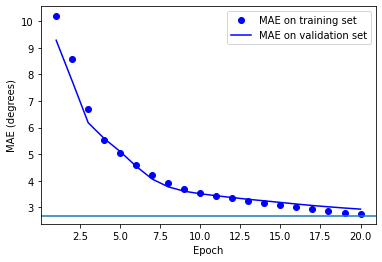

In [16]:
# Plot MAE cures for validation and training

plot_hist_regression(history_dense, baseline)

In [17]:
# We know that CNNs take advantage of neighbouring values, so why don't we try that?

# In addition to the Conv2D layers we saw last week, there are Conv1D and Conv3D layers. 
# Conv1D layers rely on 1D windows that slide across an input sequence (imagine a 1D image)

model_cnn = models.Sequential()
model_cnn.add(layers.Conv1D(8, 7, activation='relu', input_shape=(sequence_length, len(df.columns)-1)))
model_cnn.add(layers.MaxPooling1D(2))
model_cnn.add(layers.Conv1D(8, 3, activation='relu'))
model_cnn.add(layers.MaxPooling1D(2))
model_cnn.add(layers.GlobalAveragePooling1D())
model_cnn.add(layers.Dense(1))

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 8)              344       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 8)             0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 8)              200       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 8)             0         
 1D)                                                             
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                      

In [18]:
model_cnn.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_cnn = model_cnn.fit(train_dataset, epochs=n_epochs,
                            validation_data=val_dataset)

Epoch 1/20
80/80 [==============================] - 1s 4ms/step - loss: 120.7775 - mae: 9.6944 - val_loss: 95.6050 - val_mae: 8.2494
Epoch 2/20
80/80 [==============================] - 0s 3ms/step - loss: 64.3590 - mae: 6.8373 - val_loss: 40.0992 - val_mae: 5.2013
Epoch 3/20
80/80 [==============================] - 0s 2ms/step - loss: 21.4838 - mae: 3.7543 - val_loss: 19.8491 - val_mae: 3.1838
Epoch 4/20
80/80 [==============================] - 0s 2ms/step - loss: 15.5003 - mae: 3.0999 - val_loss: 18.4928 - val_mae: 3.0666
Epoch 5/20
80/80 [==============================] - 0s 2ms/step - loss: 13.9734 - mae: 2.9474 - val_loss: 17.3050 - val_mae: 2.9992
Epoch 6/20
80/80 [==============================] - 0s 2ms/step - loss: 13.0196 - mae: 2.8498 - val_loss: 16.3104 - val_mae: 2.9459
Epoch 7/20
80/80 [==============================] - 0s 2ms/step - loss: 12.3420 - mae: 2.7806 - val_loss: 15.5693 - val_mae: 2.9052
Epoch 8/20
80/80 [==============================] - 0s 2ms/step - loss: 11.

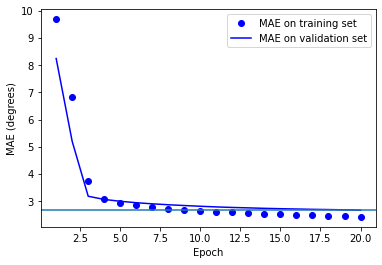

In [19]:
# Plot MAE cures for validation and training

plot_hist_regression(history_cnn, baseline)

In [33]:
#Long Short Term Memory (LSTM) Neural Networks

# 1-layer LSTM
model_lstm1 = models.Sequential()

model_lstm1.add(layers.LSTM(20, input_shape=(sequence_length, len(df.columns)-1)))
model_lstm1.add(layers.Dense(1))

model_lstm1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20)                2160      
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,181
Trainable params: 2,181
Non-trainable params: 0
_________________________________________________________________


In [34]:
n_epochs = 20

model_lstm1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_lstm1 = model_lstm1.fit(train_dataset, epochs=n_epochs,
                            validation_data=val_dataset)

Epoch 1/20
80/80 [==============================] - 2s 9ms/step - loss: 136.3206 - mae: 10.5655 - val_loss: 115.7194 - val_mae: 9.6241
Epoch 2/20
80/80 [==============================] - 0s 4ms/step - loss: 92.6458 - mae: 8.5599 - val_loss: 66.7106 - val_mae: 6.8204
Epoch 3/20
80/80 [==============================] - 0s 4ms/step - loss: 51.8373 - mae: 5.9763 - val_loss: 41.6459 - val_mae: 5.1033
Epoch 4/20
80/80 [==============================] - 0s 4ms/step - loss: 35.4502 - mae: 4.8441 - val_loss: 31.9167 - val_mae: 4.4750
Epoch 5/20
80/80 [==============================] - 0s 4ms/step - loss: 27.2068 - mae: 4.2153 - val_loss: 25.8026 - val_mae: 4.0402
Epoch 6/20
80/80 [==============================] - 0s 4ms/step - loss: 21.6602 - mae: 3.7502 - val_loss: 21.4767 - val_mae: 3.7046
Epoch 7/20
80/80 [==============================] - 0s 4ms/step - loss: 17.6300 - mae: 3.3808 - val_loss: 18.1659 - val_mae: 3.4073
Epoch 8/20
80/80 [==============================] - 0s 5ms/step - loss: 1

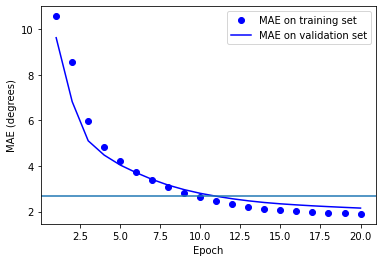

In [35]:
# Plot MAE cures for validation and training

plot_hist_regression(history_lstm1, baseline)

In [36]:
print('Test MAE = %.2f degrees' % model_lstm1.evaluate(test_dataset)[1])

31/31 [==============================] - 0s 3ms/step - loss: 8.0459 - mae: 2.2171
Test MAE = 2.22 degrees


In [41]:
# Adding dropout (to help avoid overfitting)

model_lstm2 = models.Sequential()

model_lstm2.add(layers.LSTM(20, input_shape=(sequence_length, len(df.columns)-1), recurrent_dropout=0.25))
model_lstm2.add(layers.Dropout(0.4))
model_lstm2.add(layers.Dense(1))

model_lstm2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 20)                2160      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,181
Trainable params: 2,181
Non-trainable params: 0
_________________________________________________________________


In [42]:
model_lstm2.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_lstm2 = model_lstm2.fit(train_dataset, epochs=n_epochs,
                            validation_data=val_dataset)

Epoch 1/20
80/80 [==============================] - 2s 8ms/step - loss: 143.4831 - mae: 10.6548 - val_loss: 123.6807 - val_mae: 9.6389
Epoch 2/20
80/80 [==============================] - 0s 6ms/step - loss: 101.4547 - mae: 8.6796 - val_loss: 62.0665 - val_mae: 6.3865
Epoch 3/20
80/80 [==============================] - 0s 6ms/step - loss: 52.9904 - mae: 5.9725 - val_loss: 39.9376 - val_mae: 4.9496
Epoch 4/20
80/80 [==============================] - 1s 6ms/step - loss: 37.2705 - mae: 4.9843 - val_loss: 30.8018 - val_mae: 4.3681
Epoch 5/20
80/80 [==============================] - 1s 6ms/step - loss: 30.0671 - mae: 4.4844 - val_loss: 25.1076 - val_mae: 3.9541
Epoch 6/20
80/80 [==============================] - 0s 6ms/step - loss: 25.3784 - mae: 4.0882 - val_loss: 21.3238 - val_mae: 3.6575
Epoch 7/20
80/80 [==============================] - 1s 6ms/step - loss: 22.9212 - mae: 3.8819 - val_loss: 19.0883 - val_mae: 3.4823
Epoch 8/20
80/80 [==============================] - 0s 6ms/step - loss: 

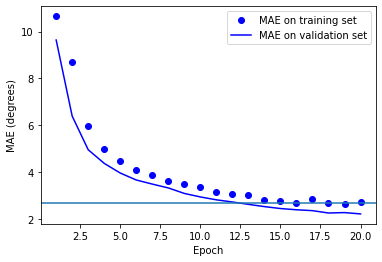

In [43]:
# Plot MAE cures for validation and training

plot_hist_regression(history_lstm2, baseline)

In [44]:
print('Test MAE = %.2f degrees' % model_lstm2.evaluate(test_dataset)[1])

31/31 [==============================] - 0s 3ms/step - loss: 8.6063 - mae: 2.2917
Test MAE = 2.29 degrees


In [51]:
# Performance in the previous figure can (maybe) still be improved
# Let's try to add some more layers -- we can do this now that we're no longer overfitting

model_lstm3 = models.Sequential()

model_lstm3.add(layers.LSTM(20, input_shape=(sequence_length, len(df.columns)-1), recurrent_dropout=0.25, return_sequences=True))  # NEW!
model_lstm3.add(layers.LSTM(20, input_shape=(sequence_length, len(df.columns)-1), recurrent_dropout=0.25))  # NEW!!
model_lstm3.add(layers.Dropout(0.4))
model_lstm3.add(layers.Dense(1))

model_lstm3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 14, 20)            2160      
                                                                 
 lstm_9 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_4 (Dropout)         (None, 20)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 21        
                                                                 
Total params: 5,461
Trainable params: 5,461
Non-trainable params: 0
_________________________________________________________________


In [52]:
model_lstm3.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

callbacks = [EarlyStopping(monitor='val_mae', patience=2)]

history_lstm3 = model_lstm3.fit(train_dataset, epochs=60,  # increased number of epochs
                            validation_data=val_dataset,
                            callbacks=callbacks)           # but added early stopping callback

Epoch 1/60
80/80 [==============================] - 3s 13ms/step - loss: 123.4710 - mae: 9.9813 - val_loss: 80.3149 - val_mae: 7.6021
Epoch 2/60
80/80 [==============================] - 1s 11ms/step - loss: 61.0563 - mae: 6.5456 - val_loss: 46.4239 - val_mae: 5.3814
Epoch 3/60
80/80 [==============================] - 1s 11ms/step - loss: 41.8637 - mae: 5.2670 - val_loss: 36.2822 - val_mae: 4.7590
Epoch 4/60
80/80 [==============================] - 1s 11ms/step - loss: 33.5150 - mae: 4.6912 - val_loss: 30.7711 - val_mae: 4.4422
Epoch 5/60
80/80 [==============================] - 1s 11ms/step - loss: 28.5376 - mae: 4.3033 - val_loss: 25.9828 - val_mae: 4.1011
Epoch 6/60
80/80 [==============================] - 1s 12ms/step - loss: 25.0612 - mae: 4.0117 - val_loss: 22.3172 - val_mae: 3.8099
Epoch 7/60
80/80 [==============================] - 1s 12ms/step - loss: 21.3167 - mae: 3.6954 - val_loss: 18.7162 - val_mae: 3.4437
Epoch 8/60
80/80 [==============================] - 1s 12ms/step - l

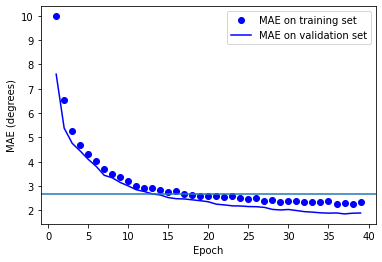

31/31 [==============================] - 0s 5ms/step - loss: 6.2963 - mae: 1.9486
Test MAE = 1.95 degrees


In [53]:
# Plot MAE cures for validation and training

plot_hist_regression(history_lstm3, baseline)
print('Test MAE = %.2f degrees' % model_lstm3.evaluate(test_dataset)[1])

Text




In [55]:
#Data prep


#We'll try to predict whether the review for a movie is positive or negative looking only at the text of the review.
#We'll use the IMDB text dataset for this task, which is available on keras.datasets 
#We'll merge the training and test sets and use 60% for training, 20% for validation, and 20% for testing.
#As this is a binary classificationp problem, we'll use the binary cross entropy loss function. We will keep track of accuracy when training and evaluating the model.

def plot_hist_classif(hist):
    n_ = len(hist.history['accuracy'])
    plt.plot(range(1, n_+1), 100*np.asarray(hist.history['accuracy']), 'bo', label='Accuracy on training set')
    plt.plot(range(1, n_+1), 100*np.asarray(hist.history['val_accuracy']), 'b', label='Accuracy on validation set')
    plt.legend()
    plt.xlabel("Epoch") 
    plt.ylabel("Accuracy")
    plt.ylim(0, 100)
    plt.axhline(y=50)
    plt.show()

In [56]:
max_features = 15000                   # only consider the top 15k words
maxlen = 500                           # first 500 words of each review
batch_size = 32

print('Loading data...')

# Load dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=max_features)

print(len(x_train), 'train sequences', x_train.shape)
print(len(x_test), 'test sequences', x_test.shape)

Loading data...
25000 train sequences (25000,)
25000 test sequences (25000,)


In [57]:
# How balanced is this dataset?

print(np.sum(y_train)/len(y_train))
print(np.sum(y_test)/len(y_test))

0.5
0.5


In [58]:
# Merge the two datasets and divide: 60% for training, 20% validation, 20% test

x_, y_ = np.concatenate((x_train, x_test)), np.concatenate((y_train, y_test))
print(x_.shape, y_.shape)

x_train, x_test, y_train, y_test = train_test_split(x_, y_, test_size=0.4, random_state=10)             # 60/40 split
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)         # 50/50 split

print(len(x_train), 'train sequences', x_train.shape)
print(len(x_val), 'validation sequences', x_val.shape)
print(len(x_test), 'test sequences', x_test.shape)

(50000,) (50000,)
30000 train sequences (30000,)
10000 validation sequences (10000,)
10000 test sequences (10000,)


In [59]:
x_train[0][:10]  # numbers!!

[1, 11531, 186, 8, 28, 6, 6482, 7, 269, 4042]

In [60]:
# We can explore what one of the reviews looks like at this point.

# Retrieve the word index file that maps words to indices
word_index = keras.datasets.imdb.get_word_index()

# Reverse the word index to obtain a dict mapping indices to words (which is what we have)
inverted_word_index = dict((i, word) for (word, i) in word_index.items())

# Decode the first sequence in the dataset
decoded_sequence = " ".join(inverted_word_index[i] for i in x_train[0])
decoded_sequence


"the lilly horror in one is fatale br looks meaningless in bronson be showing as you debut film ample to and ingredients zombi ample they for series and thought she's all manipulate and believing in j show look early last quote desire tight interesting that's kind out is far shelter but of frame br and"

In [61]:
# Let's ensure all sequences have the same length through padding


#    - shorter reviews are padded with 0's
#    - longer reviews are cut

print('Pad sequences')

x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('x_test shape:', x_test.shape)

Pad sequences
x_train shape: (30000, 500)
x_val shape: (10000, 500)
x_test shape: (10000, 500)


In [62]:
# Basic feedforward model

model = models.Sequential()

model.add(layers.Embedding(max_features, 128, input_length=maxlen))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1920000   
                                                                 
 dense_10 (Dense)            (None, 500, 64)           8256      
                                                                 
 dropout_5 (Dropout)         (None, 500, 64)           0         
                                                                 
 dense_11 (Dense)            (None, 500, 64)           4160      
                                                                 
 dropout_6 (Dropout)         (None, 500, 64)           0         
                                                                 
 flatten_1 (Flatten)         (None, 32000)             0         
                                                                 
 dense_12 (Dense)            (None, 1)                

In [63]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
938/938 [==============================] - 35s 37ms/step - loss: 0.4379 - accuracy: 0.7688 - val_loss: 0.2620 - val_accuracy: 0.8951
Epoch 2/20
938/938 [==============================] - 37s 40ms/step - loss: 0.2418 - accuracy: 0.9052 - val_loss: 0.2521 - val_accuracy: 0.8998
Epoch 3/20
938/938 [==============================] - 40s 43ms/step - loss: 0.2054 - accuracy: 0.9205 - val_loss: 0.2617 - val_accuracy: 0.8974
Epoch 4/20
938/938 [==============================] - 41s 44ms/step - loss: 0.1894 - accuracy: 0.9274 - val_loss: 0.2665 - val_accuracy: 0.8965
Epoch 5/20
938/938 [==============================] - 44s 47ms/step - loss: 0.1769 - accuracy: 0.9329 - val_loss: 0.2650 - val_accuracy: 0.8971
Epoch 6/20
938/938 [==============================] - 49s 52ms/step - loss: 0.1694 - accuracy: 0.9348 - val_loss: 0.2711 - val_accuracy: 0.8937
Epoch 7/20
938/938 [==============================] - 55s 59ms/step - loss: 0.1585 - accuracy: 0.9410 - val_loss: 0.3242 - val_accuracy:

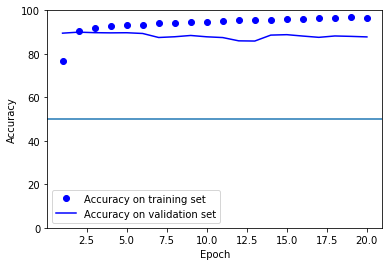

313/313 [==============================] - 2s 6ms/step - loss: 0.4038 - accuracy: 0.8834
Test Accuracy = 0.88


In [64]:
plot_hist_classif(history)
print('Test Accuracy = %.2f' % model.evaluate(x_test, y_test)[1])  # overfitting!

In [65]:
# Let's try an RNN

model = models.Sequential()
model.add(layers.Embedding(max_features, 64))
model.add(layers.LSTM(128, return_sequences=False))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          960000    
                                                                 
 lstm_10 (LSTM)              (None, 128)               98816     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,058,945
Trainable params: 1,058,945
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
938/938 [==============================] - 397s 423ms/step - loss: 0.4292 - accuracy: 0.8120 - val_loss: 0.3359 - val_accuracy: 0.8708
Epoch 2/20
938/938 [==============================] - 467s 498ms/step - loss: 0.2861 - accuracy: 0.8880 - val_loss: 0.3305 - val_accuracy: 0.8685
Epoch 3/20
938/938 [==============================] - 530s 565ms/step - loss: 0.2387 - accuracy: 0.9106 - val_loss: 0.2881 - val_accuracy: 0.8914
Epoch 4/20
938/938 [==============================] - 531s 567ms/step - loss: 0.2080 - accuracy: 0.9217 - val_loss: 0.3805 - val_accuracy: 0.8801
Epoch 5/20
938/938 [==============================] - 478s 510ms/step - loss: 0.1882 - accuracy: 0.9313 - val_loss: 0.2965 - val_accuracy: 0.8954
Epoch 6/20
938/938 [==============================] - 457s 487ms/step - loss: 0.1681 - accuracy: 0.9401 - val_loss: 0.2692 - val_accuracy: 0.8892
Epoch 7/20
938/938 [==============================] - 451s 480ms/step - loss: 0.1505 - accuracy: 0.9479 - val_loss: 0.3120 -

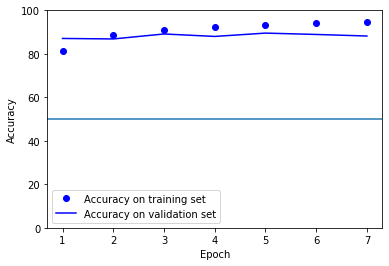

313/313 [==============================] - 47s 149ms/step - loss: 0.3087 - accuracy: 0.8872
Test Accuracy = 0.89


In [66]:
# This model will take a long time to train, so we add an early stopping criterion
# N.B: It's actually much faster to train WITHOUT A GPU!!

callbacks = [EarlyStopping(monitor='val_accuracy', patience=2)]
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=20, validation_data=(x_val, y_val), callbacks=callbacks)
plot_hist_classif(history)

print('Test Accuracy = %.2f' % model.evaluate(x_test, y_test)[1])
# Note that we're still overfitting, but this is just an example of use

My Turn!!!!

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          960000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         24832     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,009,729
Trainable params: 1,009,729
N

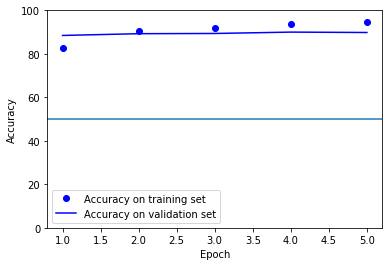

313/313 [==============================] - 44s 136ms/step - loss: 0.2533 - accuracy: 0.9012
Test Accuracy = 0.90


In [67]:
n_ = 5        # number of epochs.

model = models.Sequential()

model.add(layers.Embedding(max_features, 64))
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=False)))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation="sigmoid"))


# I DON'T RECOMMEND THAT YOU CHANGE CODE AFTER THIS POINT
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

print(model.summary())

# This model will take a long time to train, so we add an early stopping criterion
# I've also added a ModelCheckpoint that will save the best model according to val_accuracy regardless of whether we continue training

callbacks = [EarlyStopping(monitor='val_accuracy', patience=1),
             ModelCheckpoint("model.keras", save_best_only=True, monitor="val_accuracy", mode='max')]

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=n_, 
                    validation_data=(x_val, y_val), 
                    callbacks=callbacks)

plot_hist_classif(history)
model = keras.models.load_model("model.keras")

print('Test Accuracy = %.2f' % model.evaluate(x_test, y_test)[1])

In [70]:
if model.count_params() > 1000000:
    print("Due to memory constraints on Moodle, the lab quiz has a 10MB limit on your model size, so you need to use a smaller model to validate through the auto-marker.")

if history.history["val_accuracy"][-1] > 0.8:
    print("Your model is accurate enough!")

else:
    print("Accuracy is below the threshold!")
    raise Exception("Your model isn't accurate enough to pass the progress checker!")
    
# Save the model into a local folder
keras.models.save_model(model, "Model.h5",save_format='h5')

print('Model saved! You can now upload it to the lab quiz.')

Due to memory constraints on Moodle, the lab quiz has a 10MB limit on your model size, so you need to use a smaller model to validate through the auto-marker.
Your model is accurate enough!
Model saved! You can now upload it to the lab quiz.
